# Planar Data Classifier with one hidden layer

---

## 1. Introduction

This model is my first model with two layers, which is written in simple python. We're given datasef of points (x, y, color). Classifier's goal is to define color regions. Most probably, this data classifier cannot help you. It is her just to represent my progress in Machine Learning.

## 2. Imports
* [numpy](https://www.numpy.org/) - for SIMD np.array, and for math.
* [sklearn](http://scikit-learn.org/stable/) -  provides simple and efficient tools for data mining and data analysis.
* [matplotlib](http://matplotlib.org) - for data graphs plotting.

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

---

## 3. Defining our dataset

Dataset is generated through this math function, which prepares "flower" like data

In [2]:
def load_planar_dataset():
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

Let's visualize it

The shape of X is: (2, 400). 
The shape of Y is: (1, 400). 
We have m = 400 training examples!

X[0][i] is point's X coordinate, X[1][i] is point's Y coordinate, Y[0][i] is point's color
Example point [0.4921887860618483, 2.626843149167457] has color 0)


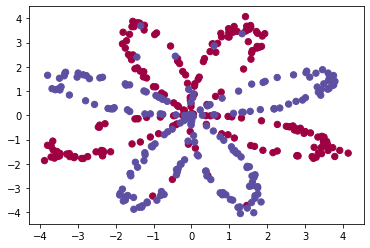

In [3]:
X, Y = load_planar_dataset()

print(f"The shape of X is: {str(X.shape)}. ")
print(f"The shape of Y is: {str(Y.shape)}. ")
print(f"We have m = {(X.shape[1])} training examples!\n")

point_index = 0
print(f"X[0][i] is point's X coordinate, X[1][i] is point's Y coordinate, Y[0][i] is point's color")
print(f'Example point [{X[0][point_index]}, {X[1][point_index]}] has color {Y[0][point_index]})')

plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

## 4. Solving problem with logistic regression

Before building a full neural network, lets first see how logistic regression performs on this problem. We'll use sklearn's built-in functions to train logistic regression classifier.

In [4]:
# Train the logistic regression classifier
logistic_regression_classifier = sklearn.linear_model.LogisticRegressionCV(cv=3);
logistic_regression_classifier.fit(X.T, Y[0].T);

We'll be ploting resluts with this functions, which prints colored decition boundary

In [5]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap=plt.cm.Spectral)

Let's plot decision boundary of our classifier with our newly written function

Accuracy of logistic regression: 48.75% (percentage of correctly labelled datapoints)


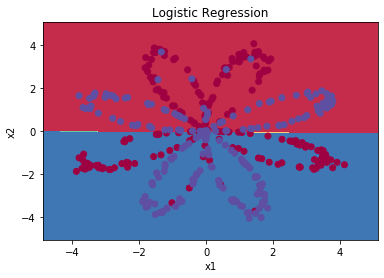

In [6]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: logistic_regression_classifier.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
logistic_regression_predictions = logistic_regression_classifier.predict(X.T)
logistic_regression_accuracy = float((np.dot(Y,logistic_regression_predictions) + np.dot(1-Y,1-logistic_regression_predictions))/float(Y.size)*100)
print(f"Accuracy of logistic regression: {logistic_regression_accuracy}% (percentage of correctly labelled datapoints)")

Well, that's a shame. Logistic regression sucks, coz it can only linearly separate data. We need to do better.

## 5. Solving problem with one hidden layer Neural Network 

In order to see non linear relations - we need hidden layer. Why?

* Think of linear regression's final formula. It'll be like this `y = w*x + b` (linear)
* Think of our two layer linear net. The final formula will be like this `y = (w*x0 + b)*((w*a1 + b)) + (w*x1 + b)*((w*a1 + b)) + ...` (this function is intuitivelly curved, coz there are more than 1 `x`. I'll not prove it mathematically, go study some math, haha :)). My point is that the final formula will output curved function.

### 5.1 Coding model

#### 5.1.1 Model's Architecture

**Diagram**:  

<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, we can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

#### 5.1.2 Defining structure

In [7]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

#### 5.1.3 Implementing parameters initialization

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

#### 5.1.4 Implementing forward propagation

Firstly, we'll need to code `sigmoid` function

In [9]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

Let's use it in forward_propagation

In [10]:
def forward_propagation(X, parameters):
    """
    Arguments:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    # Retrieving each parameter
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Actual forward propagation logic
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    # Storing in progress values to cache array
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    
    return A2, cache

#### 5.1.5 Implementing backward propagation

Now we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

In [11]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(Y, np.log(A2)) + np.multiply((1 - Y), np.log(1 - A2))
    cost = np.multiply(-(1 / m), np.sum(logprobs))
    cost = float(np.squeeze(cost))  # turns [[17]] into 17 
    
    return cost

Using the cache computed during forward propagation, we can now implement backward propagation.

Backpropagation is usually the hardest (most mathematical) part in deep learning. Here again is all the formulas, which are gathered by getting backward derivatives

<img src="images/grad_summary.png" style="width:600px;height:300px;">

In [12]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implements the backward propagation
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # Retrieve all the necessary parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Computing derivatives from formula
    dZ2 = A2 - Y
    dW2 = np.multiply(1 / m, np.dot(dZ2, A1.T))
    db2 = np.multiply(1 / m, np.sum(dZ2, axis = 1, keepdims = True))
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = np.multiply(1 / m, np.dot(dZ1, X.T))
    db1 = np.multiply(1 / m, np.sum(dZ1, axis = 1, keepdims = True))
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    
    return grads

#### 5.1.6 Implementing update rule 

In [13]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule
    
    Arguments:
    parameters -- python dictionary containing parameters 
    grads -- python dictionary containing gradients 
    
    Returns:
    parameters -- python dictionary containing updated parameters 
    """
    # Retrieve all the neccessary parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

#### 5.1.7 Composing everything to model function

In [14]:
def model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(17) # So that results are consistent

    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
                
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return parameters

#### 5.1.8 Implementing predict function

In [15]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

### 5.2 Testing model


#### 5.2.1 Running our model on our dataset
It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693227
Cost after iteration 1000: 0.204129
Cost after iteration 2000: 0.195853
Cost after iteration 3000: 0.192771
Cost after iteration 4000: 0.191038
Cost after iteration 5000: 0.189842
Cost after iteration 6000: 0.188918
Cost after iteration 7000: 0.188157
Cost after iteration 8000: 0.187504
Cost after iteration 9000: 0.186928


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

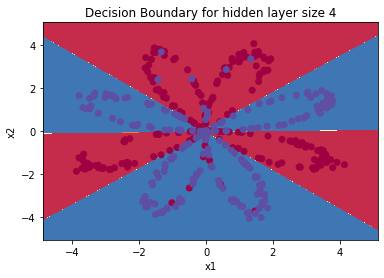

In [16]:
# Build a model with a n_h-dimensional hidden layer
parameters = model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [17]:
# Print accuracy
predictions = predict(parameters, X)
nn_accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)

print (f"Accuracy of two layer nn: {nn_accuracy}%")
print(f"Accuracy of logistic regression: {logistic_regression_accuracy}%")

Accuracy of two layer nn: 94.75%
Accuracy of logistic regression: 48.75%


Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

#### 5.2.2 Tuning hidden layer size

Let's test different hidden layer sizes, and find the best one!

Accuracy for 1 hidden units: 71.25 %
Accuracy for 2 hidden units: 71.25 %
Accuracy for 3 hidden units: 94.75 %
Accuracy for 4 hidden units: 94.75 %
Accuracy for 5 hidden units: 94.75 %
Accuracy for 20 hidden units: 94.75 %
Accuracy for 50 hidden units: 94.5 %


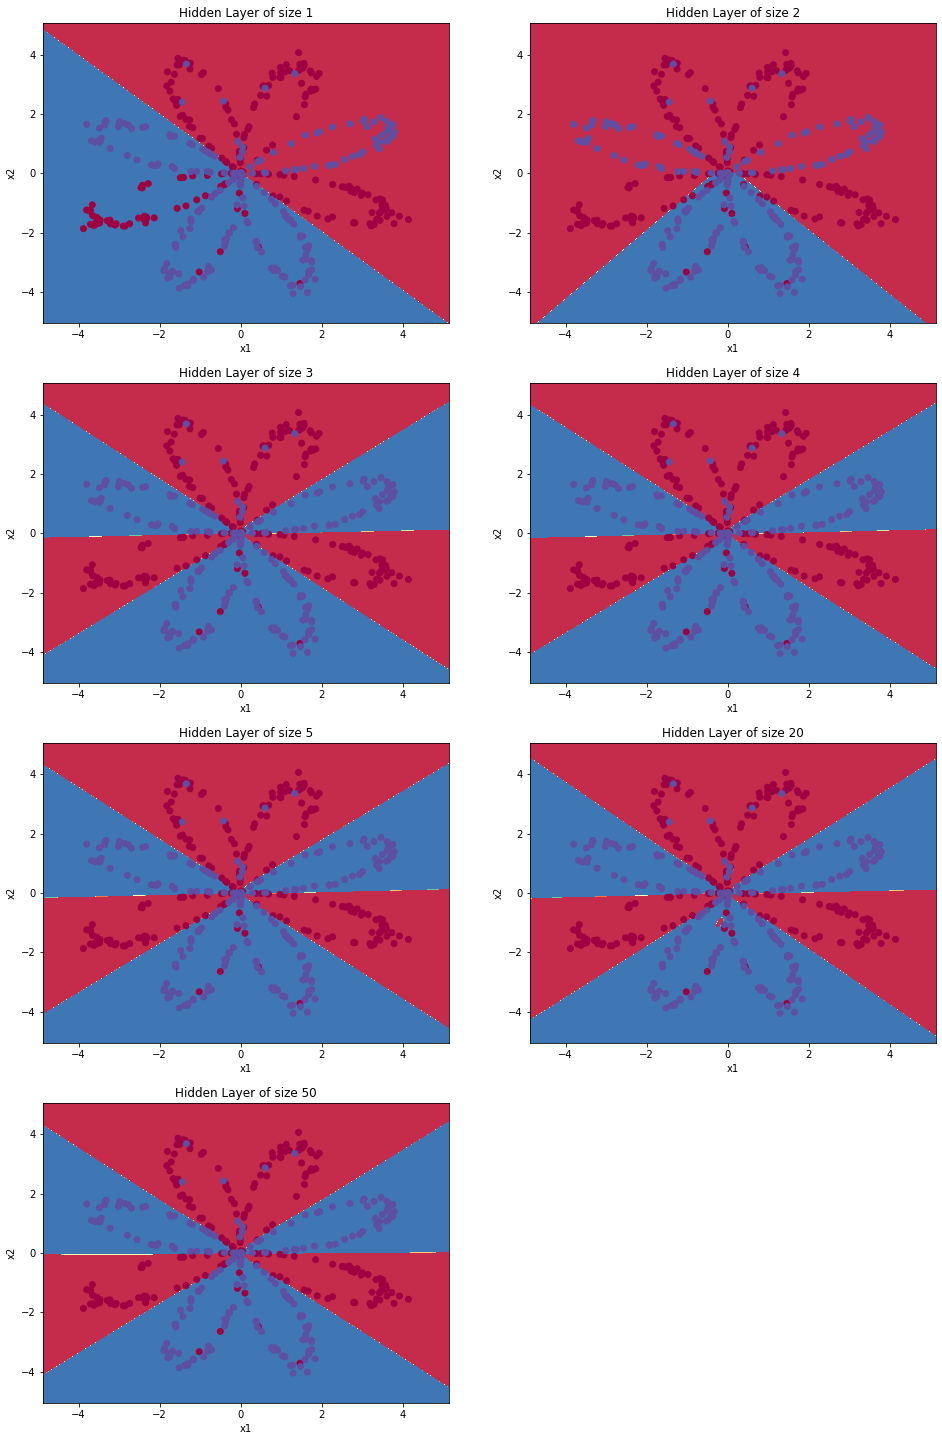

In [18]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = model(X, Y, n_h, num_iterations = 5000)
    
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.
- And ye, we don't use regularization, because i didn't knew of it at the moment

## 6. Last words

Thx for an amazing [Coursera course](https://www.coursera.org/learn/neural-networks-deep-learning) from Andrew NG for this assignment. I really enjoyed it, and learned a lot from it :) 

I Hope, that if you read my code - you enjoyed it too. Thank you and bye!